# Korean Chatbot - built with transformer

Goal of this project:
1. Understand the Transformer's Encoder-Decoder Structure
2. Use the inner word tokenizer
3. Understand self-attention
4. In Korean

## Dataset
I downloaded the Korean chatbot dataset from songys' Chatbot_data repo: https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

## Table of Contents
1. Load the Dataset
2. Data Preprocessing
3. SubwordTextEncoder
4. Model Configuration
5. Model Test



# 1. Load the Dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd 
from sklearn.model_selection import train_test_split

In [8]:
def load_data():
    questions=[]
    answers=[]
    with open('./data/ChatbotData.csv','r',encoding="utf-8") as f:
        for line in f.read().splitlines():
            questions.append(line.split(',')[0:1][0])
            answers.append(line.split(',')[1:2][0])
        questions, answers, test_Q, test_A = train_test_split(questions, answers, test_size=0.05, random_state=42)
    return questions, answers, test_Q, test_A

In [9]:
questions, test_Q, answers, test_A = load_data()

In [10]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))
print('테스트 샘플 수 :', len(test_Q))
print('테스트 샘플 수 :', len(test_A))

전체 샘플 수 : 11232
전체 샘플 수 : 11232
테스트 샘플 수 : 592
테스트 샘플 수 : 592


# 2. Data Preprocessing

In [11]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [12]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

## Positional Encoding

A transformer that receives all the words in a sentence at once may not be able to distinguish between 'I ate lunch' and 'lunch ate I'. So, even for the same word, in order to additionally inform the model of which word order the word is entered in the sentence, it needs to be in the embedding vector of the word and the vector (Positional Encoding) value with positional information is added to the model.

In [13]:
# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # Apply sin function to the even number of index of the array 
    sines = tf.math.sin(angle_rads[:, 0::2])
    # Apply cosine function to the odd index
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In Transformer, the following formula was used to calculate the attention value.

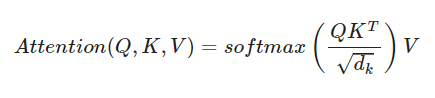

Q, K, V stands for Query, Key, and Value, respectively.   

Attention function calculates the similarity with all 'Keys' for a given 'Query'. And the obtained similarity is reflected in each 'Value' mapped with the key. And if you add up all the 'Values' reflecting the similarity and combine them, this is called the Attention Value, which is the final result.   

1. Q, K, and V are sentence matrices with word vectors as rows.
2. The dot product of a vector refers to the similarity of the vectors.
3. Using a specific value as the denominator is for scaling that adjusts the size of the value.

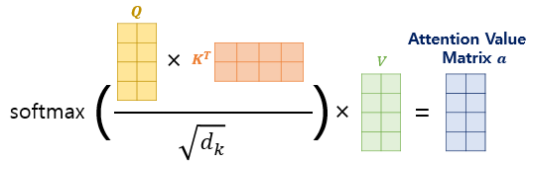

In [14]:
# Scaled dot product attention function 
def scaled_dot_product_attention(query, key, value, mask):
  # dot product of Q and K
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

Performing attention in parallel is called multi-head attention.

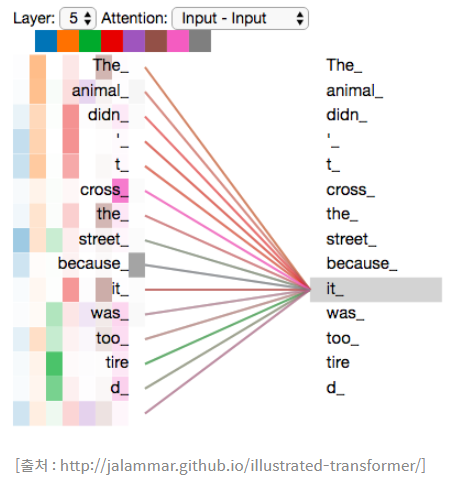

In [15]:
# Multihead Attention
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # Create multiple heads for parallel operations.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # Scaled dot-product attention function
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # Reconcatenate each result after attention operation.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

Padding is a natural language preprocessing method that adjusts the length of sentences by filling in the number 0 for sentences shorter than the length set in the process of making all sentences the same length when sentences have different lengths.

The picture above is a visualization of the padding process using Keras' pad_sequences().

However, in fact, since the given number 0 is not a word with real meaning, it needs to be excluded from calculations such as actual attention. The padding masking checks where the number 0 is for this.

Here is a function that implements padding masking.

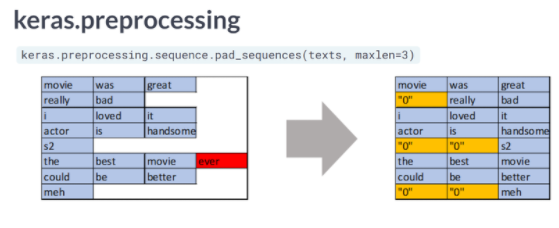

In [16]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In the picture below, the part colored in red represents masking. Red serves as a mask in the actual attention calculation, so that the similarity can be obtained only with previous words based on the current word during attention calculation. Let's take a look at the matrix slowly, considering that the row is a Query and the column is a key.

For example, if the Query word is 'finding', only the columns < s>, <나는>, <행복을>, and <찾고> are displayed in this 'find' row, and the columns after that are painted in red. In other words, similarity cannot be obtained. Implementing that red part as a masking function is as follows.

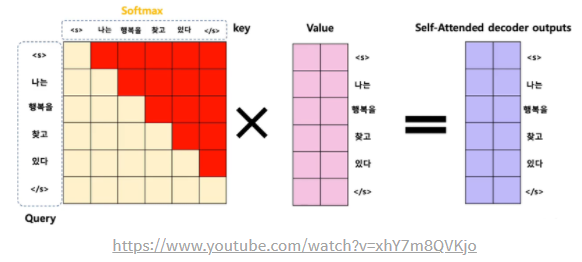

In [17]:
# Look ahead masking
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

## Encoder and Decoder

You can see that the number 1 is filled in in the form of a diagonal line. However, since this masking and padding masking are separate, when performing this masking, if there is a word with the number 0, it must also be padded. So, the create_look_ahead_mask() function is also calling the previously implemented padding mask function internally.

Let's test even if the number 0 is included.

In [18]:
# Implement one encoder layer as a function.
# Two sub-layers exist within this single layer.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # Use Padding mask
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 1st sub-layer: Perform multi-head attention (self-attention)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # The result of attention performs techniques that help training called Dropout and Layer Normalization.
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # Second sub-layer: 2 fully connected layers
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # The result of the fully connected layer performs techniques that help training called Dropout and LayerNormalization.
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Encoder
One encoder layer is largely divided into two sublayers.
These are self-attention and feed-forward neural networks. Self-attention is done in parallel with multi-head attention.

A function that implements one encoder layer with two sublayers is: the first sublayer and the second sublayer inside the function.

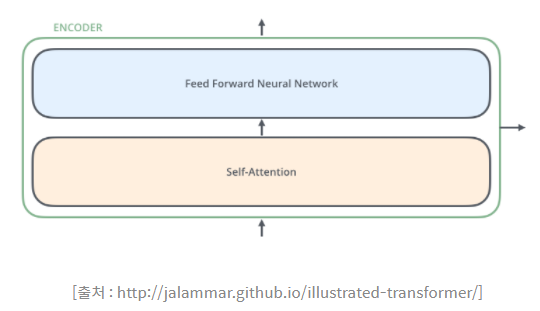

### Build encoders by stacking layers of encoders

The encoder layer implemented in this way connects the embedding layer and the positional encoding, and the encoder of the transformer is completed by stacking as many encoder layers as the user wants.

Inside the encoder and decoder, a technique called Layer Normalization is used to help train after each sub-layer.

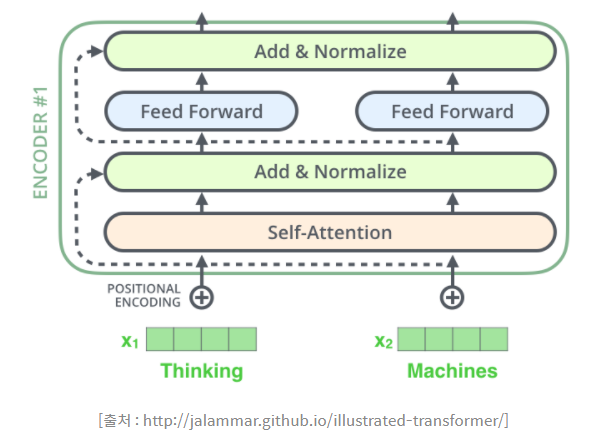

In [19]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # use padding mask
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # Embedding Layer
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # Positional Encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # Layers of encoders stacked by num_layers.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Decoder

Like the encoder's self-attention, both the decoder's self-attention and the encoder-decoder's attention perform scaled dot product attention in parallel with multi-head attention.

The function of the decoder, which internally implements the three sublayers of the decoder, is as following.

In [20]:
# Implement one decoder layer as a function.
# There are three sub-layers within this one layer.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 1st sub-layer: Perform multi-head attention (self-attention)
Translation results
1st sub-layer: Perform multi-head attention (self-attention) 
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # The result of multi-head attention performs a technique that helps training called LayerNormalization.
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # Second sub-layer: Masked multi-head attention (encoder-decoder attention)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # The result of masked multi-head attention is
  # Perform techniques that help training called Dropout and LayerNormalization
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 3rd sub-layer: 2 fully connected layers
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # Dropout and LayerNormalization are performed on the result of the fully connected layer.
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### Build decoders by stacking decoder layers

In [21]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # Padding Mask
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # Embedding Layer
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # Positional Encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Perform a training aid technique called dropout
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## Get parallel data from chatbot

The goal:
1. A fixed number of 50,000 question-and-answer pairs is extracted.
2. Add spaces between words and punctuation in a sentence.
3. Alphabet and ! ? , . Except for these 4 punctuation marks, all other special characters are removed.

In [25]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

In [26]:
# Maximum number of samples to use
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [27]:
# A data load function to construct a dataset that is a question-and-answer pair.
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
			# 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

# 3. SubwordTextEncoder

TODO in this stage:
1. Use TensorFlow Datasets SubwordTextEncoder as tokenizer. Tokenize based on subwords, which are smaller units than words, and encode each token into a unique integer.
2. Tokenize each statement and add START_TOKEN and END_TOKEN to indicate the start and end of each statement.
3. Sentences exceeding 40 with a maximum length of MAX_LENGTH are filtered out.
4. Sentences shorter than MAX_LENGTH are padded to fit 40.

## (a) Create Vocab dictionary
First, let's create a Vocabulary to give each word a unique integer index. When you create a vocabulary, you create it using both the question and answer dataset.

In [31]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [30]:
# Give the start and end tokens unique integers.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [32]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [7841]
END_TOKEN의 번호 : [7842]


In [33]:
# Calculate the size of the vocabulary by adding +2 considering the start and end tokens.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

7843


## (b) Integer encoding & Padding each word as a unique integer

If you have defined a tokenizer and created a Vocabulary using SubwordTextEncoder of tensorflow_datasets above, you can convert each word to an integer with tokenizer.encode(), or you can convert a sequence of integers to a sequence of words with tokenizer.decode().

In [34]:
# Perform integer encoding on the 22nd random sample.
# Convert each token to a unique integer
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [3060, 2107, 4246, 343]
정수 인코딩 후의 21번째 답변 샘플: [5477, 1453, 7631]


In [35]:
# The maximum allowable length of the sample or the final length after padding.MAX_LENGTH = 40
print(MAX_LENGTH)

40


Based on the Vocabulary, where each word is given a unique integer, you can see the result of the sequence of words encoded as a sequence of integers. As with the above result, integer encoding is performed for all sets of questions and answers. At the same time, we set the maximum length of the sentence and pad it to that length.

In [36]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # Add start and end tokens during integer encoding    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

      # Allowed as a dataset only if the maximum length is less than 40    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
      # pad all datasets to a maximum length of 40  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

When the length of the sample exceeds 40 while performing the integer encoding process, some samples were excluded because the samples were filtered. Let's check the size of the vocabulary and the number of samples.

In [37]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 7843
필터링 후의 샘플 개수: 11232
필터링 후의 샘플 개수: 11232


## (C) Using Teacher Forcing

The tf.data.Dataset API is an API that builds an input pipeline to speed up the training process.

In order to actively use this, a question and answer pair is put as an input of tf.data.Dataset.

Construct a pipeline using question-and-answer pairs as input to the tf.data.Dataset API. At this time, for teacher coercion, answers[:, :-1] is used as the input value of the decoder, and answers[:, 1:] is used as the label of the decoder.

In [38]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 4. Model Configuration

In [39]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # Mask for padding in encoder
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # Used by the decoder to mask future tokens.
   # Also includes padding mask internally.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # Mask the encoder vectors in the second attention block
   # mask for padding in decoder
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # Encoder
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # Decoder
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # fully connected layer
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## (a) Create Model

In [40]:
tf.keras.backend.clear_session()

# Hyperparameters
NUM_LAYERS = 2 # Number of layers of encoder and decoder
D_MODEL = 256 # Fixed dimensions of inputs and outputs inside encoders and decoders
NUM_HEADS = 8 # Number of heads in multi-head attention
UNITS = 512 # The size of the hidden layer of the feed-forward neural network
DROPOUT = 0.1 # dropout rate

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3062016     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## (b) Loss Function

Since the label sequence is padded, we need to apply a padding mask when calculating the loss.

In [41]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

## (c) Customized Learning Rate

When training a deep learning model, the learning rate is a very important hyperparameter. Recently, advanced techniques that rapidly increase the learning rate at the beginning of model training and then gradually lower it as the train step progresses are widely used to converge stably. This method is called Custom Learning rate Scheduling.

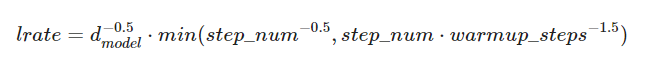

In [42]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

The smaller of the part proportional to and the part proportional to step_numstep_num is selected. So, you can see that learning_rate increases in proportion to step_numstep_num at the beginning of learning and decreases thereafter.

Text(0.5, 0, 'Train Step')

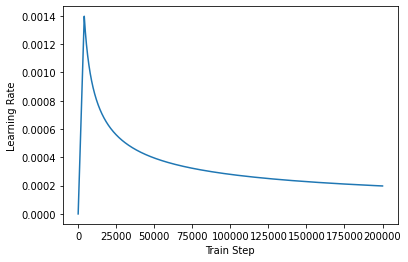

In [43]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## (d) Model Compile

Compile the model using a loss function and a custom learning rate.

In [44]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [45]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
176/176 [==============================] - 32s 144ms/step - loss: 1.5316 - accuracy: 0.0125
Epoch 2/50
176/176 [==============================] - 25s 140ms/step - loss: 1.2657 - accuracy: 0.0477
Epoch 3/50
176/176 [==============================] - 25s 144ms/step - loss: 1.0428 - accuracy: 0.0497
Epoch 4/50
176/176 [==============================] - 25s 144ms/step - loss: 0.9406 - accuracy: 0.0530
Epoch 5/50
176/176 [==============================] - 25s 143ms/step - loss: 0.8903 - accuracy: 0.0562
Epoch 6/50
176/176 [==============================] - 25s 142ms/step - loss: 0.8330 - accuracy: 0.0603
Epoch 7/50
176/176 [==============================] - 25s 143ms/step - loss: 0.7711 - accuracy: 0.0656
Epoch 8/50
176/176 [==============================] - 25s 144ms/step - loss: 0.6987 - accuracy: 0.0729
Epoch 9/50
176/176 [==============================] - 25s 140ms/step - loss: 0.6206 - accuracy: 0.0809
Epoch 10/50
176/176 [==============================] - 25s 144ms/step - l

# 5. Model Test

The inference phase basically goes through the following steps:

1. New input sentences undergo the same preprocessing as in training.
2. Tokenize the input statement, and add START_TOKEN and END_TOKEN.
3. Calculate padding masking and look-ahead masking.
4. The decoder predicts the next word from the input sequence.
5. The decoder adds the next predicted word to the existing input sequence and uses it as a new input.
6. When END_TOKEN is predicted or the maximum length of the sentence is reached, the decoder stops.

In [46]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # After integer encoding the input sentence, add start token and end token before and after.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

# Variable in which the output sequence predicted up to now of the decoder is continuously stored.
   # Since there is no prediction at first, only the start token is stored separately. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # Decoder's inference stage
  for i in range(MAX_LENGTH):
    # The decoder iterates over the next word prediction for a length of up to MAX_LENGTH.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # Integer of the currently predicted word
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # If the currently predicted word is the termination token, the for statement is terminated.
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

# Predicted words are continuously added to output_sequence.
     # This output_sequence becomes the input of the decoder again.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [47]:
def sentence_generation(sentence):
  # Runs the decoder on the input sentence and returns the predicted sequence of integers.
  prediction = decoder_inference(sentence)

  # Converts a sequence of integers back to a sequence of text.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

# 6. Run Chatbot

In [48]:
sentence_generation('집에 가고 싶다.')

입력 : 집에 가고 싶다.
출력 : 시작이 있으면 끝도 있는 법이에요.


'시작이 있으면 끝도 있는 법이에요.'

In [49]:
sentence_generation('놀러 가고 싶다.')

입력 : 놀러 가고 싶다.
출력 : 시작이 있으면 끝도 있는 법이에요.


'시작이 있으면 끝도 있는 법이에요.'

In [50]:
sentence_generation('보고 싶다')

입력 : 보고 싶다
출력 : 저랑 놀아요.


'저랑 놀아요.'

In [54]:
sentence_generation('여행 가고 싶다')

입력 : 여행 가고 싶다
출력 : 저랑 놀아요.


'저랑 놀아요.'

In [53]:
sentence_generation('베고파')

입력 : 베고파
출력 : 저랑 놀아요.


'저랑 놀아요.'

In [55]:
sentence_generation('심심해')

입력 : 심심해
출력 : 저랑 놀아요.


'저랑 놀아요.'

In [57]:
sentence_generation('공부 하기 싫다')

입력 : 공부 하기 싫다
출력 : 저랑 놀아요.


'저랑 놀아요.'

In [59]:
sentence_generation('졸려')

입력 : 졸려
출력 : 저랑 놀아요.


'저랑 놀아요.'

In [62]:
sentence_generation('저녁 뭐 먹지?')

입력 : 저녁 뭐 먹지?
출력 : 저는 사람으로 태어나고 싶어요.


'저는 사람으로 태어나고 싶어요.'

# Conclusion
## Results
- The performance was not very good, it is repeating some words that are already existed from the original chatbot dataset. 
- Also, when I tried to ask a question, the model answered with words out of context.

## What I've learned
- Understand the Transformer's Encoder-Decoder Structure
- Use the inner word tokenizer
- Understand self-attention
- Create Chatbot model and generate Korean text